<a href="https://colab.research.google.com/github/timonpalm/TFCourse/blob/main/07_food_vision_milestone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Check GPU

Not all GPU's are compatible with Mixture Learning. GPU needs to have a combuting factor equal or higher than 7.0.
So choose Tesla T4 GPU

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b633579f-af37-0e13-0a6e-be839795a2ba)


In [3]:
# Download helper function
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-18 13:04:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-18 13:04:47 (25.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys


## Use Tensorflow Dataset to download data

In [5]:
# Get Tensorflow Datasets
import tensorflow_datasets as tfds

In [6]:
datasets_list = tfds.list_builders()
datasets_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bot_adversarial_dialogue',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_h',
 'cifar10_n',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2002',
 

In [27]:
# Load in the data (takes 506 minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

## Exploring the data

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
train_one_sample = train_data.take(1)

In [11]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image sahpe: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image sahpe: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 23
  Class name: churros
  


In [13]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[189, 165, 121],
        [185, 161, 117],
        [181, 157, 113],
        ...,
        [111,  72,  33],
        [103,  64,  25],
        [ 94,  55,  16]],

       [[186, 162, 118],
        [183, 159, 115],
        [180, 156, 112],
        ...,
        [122,  83,  40],
        [113,  74,  31],
        [105,  66,  23]],

       [[180, 156, 112],
        [178, 154, 110],
        [177, 153, 109],
        ...,
        [132,  94,  45],
        [124,  87,  35],
        [120,  83,  31]],

       ...,

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [231, 225, 191],
        [231, 225, 189],
        [231, 226, 188]],

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [230, 224, 190],
        [230, 224, 188],
        [229, 223, 187]],

       [[206, 203, 158],
        [204, 200, 153],
        [203, 195, 146],
        ...,
        [229, 223, 18

In [14]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Dataset

(-0.5, 511.5, 511.5, -0.5)

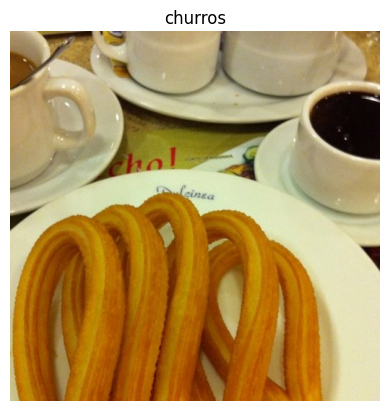

In [15]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [28]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return (tf.cast(image, tf.float32), label)

In [24]:
preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[184.91327 , 160.91327 , 116.91326 ],
        [180.35715 , 156.35715 , 112.35714 ],
        [183.71428 , 160.71428 , 118.71429 ],
        ...,
        [147.5915  , 108.66289 ,  69.08129 ],
        [123.576454,  84.576454,  44.198887],
        [106.44359 ,  67.44359 ,  25.872158]],

       [[174.66837 , 150.66837 , 106.668365],
        [175.14285 , 151.14285 , 107.14286 ],
        [177.80103 , 153.22958 , 112.015305],
        ...,
        [155.61722 , 119.545784,  68.443695],
        [145.1989  , 108.19381 ,  53.423363],
        [134.37747 ,  98.30605 ,  40.73462 ]],

       [[172.70918 , 148.70918 , 104.70918 ],
        [173.57143 , 149.57143 , 105.57143 ],
        [174.02042 , 149.35713 , 108.188774],
        ...,
        [148.12747 , 113.265205,  55.984566],
        [150.02548 , 114.25507 ,  53.066288],
        [147.08171 , 111.86743 ,  48.724575]],

       ...,

       [[202.92854 , 198.92854 , 151.20917 ],
        [202.

## Batch and prepare datasets

We're now going to make our data input pipeline really fast.

In [29]:
# map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [30]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

In [50]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

In [32]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

## build feature extraction model

In [45]:
from tensorflow.keras import layers

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNet has rescaling built-in

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="predictions")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [46]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 predictions (Activation)    (None, 101)               0         
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (

## Checking layer dtype policies

In [47]:
# Check the dtype_policy
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
predictions True float32 <Policy "float32">


In [48]:
# Check the dtype in EfficientNet:
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_4 False float32 <Policy "mixed_float16">
normalization_2 False float32 <Policy "mixed_float16">
rescaling_5 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

## Fit the Feature Extraction Model

In [49]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                      steps_per_epoch=len(train_data),
                                                      validation_data=test_data,
                                                      validation_steps=int(.15 * len(test_data)),
                                                      callbacks=[model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7163 - accuracy: 0.5826

2368/2368 [==============================] - 181s 71ms/step - loss: 1.7163 - accuracy: 0.5826 - val_loss: 1.1176 - val_accuracy: 0.7044
Epoch 2/3
2366/2368 [============================>.] - ETA: 0s - loss: 1.1985 - accuracy: 0.6890

2368/2368 [==============================] - 174s 73ms/step - loss: 1.1985 - accuracy: 0.6890 - val_loss: 1.0272 - val_accuracy: 0.7222
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0541 - accuracy: 0.7246

2368/2368 [==============================] - 168s 70ms/step - loss: 1.0541 - accuracy: 0.7246 - val_loss: 0.9853 - val_accuracy: 0.7278
